In the following, we experiment with aDM-identifiability of conformal maps.

In [1]:
from jax import numpy as np
from jax import random

import numpy as onp

In [2]:
rng, flow_rng = random.split(random.PRNGKey(0))
key = rng

0. Generate and plot sources

In [3]:
# N:=Number of samples
N = 1000
# D:=Number of dimensions
D = 2

# Generate the samples
S = random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

S -= 0.5

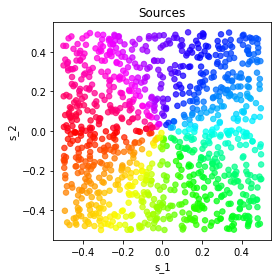

In [4]:
from plotting import cart2pol, scatterplot_variables

_, colors = cart2pol( S[:,0], S[:,1])

# Plot the sources
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

1. Generate maps with $\operatorname{aDM}=0$

**Conformal maps in $D=2$**: Uncomment the two cells below to use a mixing based on conformal maps in 2d.

In [5]:
# from mixing_functions import build_conformal_map

In [6]:
# # nonlinearity = lambda x : x**3
# # nonlinearity = lambda x : np.sqrt(2/x)
# # nonlinearity = lambda x : np.tanh(1.5*x)
# # nonlinearity = lambda x : np.log(x)
# # nonlinearity = lambda x : np.sinh(x)
# nonlinearity = lambda x : np.exp(1.1*x)

# mixing, mixing_gridplot = build_conformal_map(nonlinearity)

**Möbius transformations in $D \geq 2$**: Uncomment the two cells below to use a mixing based on Möbius transformations, see link below:

https://en.wikipedia.org/wiki/M%C3%B6bius_transformation#Higher_dimensions

In [7]:
from mixing_functions import build_moebius_transform

In [8]:
# Generate a random orthogonal matrix
from scipy.stats import ortho_group # Requires version 0.18 of scipy

A = ortho_group.rvs(dim=D)

# Scalar
alpha = 2.0
# Two vectors with data dimensionality
a = 2.0 * np.ones(D) # a vector in \RR^D
b = 3.0 * np.ones(D) # a vector in \RR^D

from jax import vmap
mixing, _ = build_moebius_transform(alpha, A, a, b, epsilon=2)
mixing_batched = vmap(mixing)

In [9]:
from jax import vmap

mixing_batched = vmap(mixing)

In [10]:
X = mixing_batched(S)
X -= np.mean(X, axis=0)

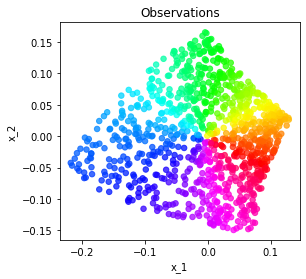

In [11]:
scatterplot_variables(X, 'Observations', colors=colors, savefig=False)#True, fname="observations_flow")

2. Learn an autoregressive flow to fit the data

In [12]:
from real_nvp import real_nvp_and_inv

realnvp, realnvp_inv = real_nvp_and_inv(D)

In [13]:
from jax import jacfwd

v_realnvp = vmap(realnvp, (0, None, None, None, None))
v_realnvp_inv = vmap(realnvp_inv, (0, None, None, None, None))
J_realnvp = jacfwd(realnvp)
v_J_realnvp = vmap(J_realnvp, (0, None, None, None, None))
vdet = vmap(np.linalg.det)

In [14]:
from real_nvp import nf_init, nf_forward, nf_backward

In [15]:
# Initialize a normalizing flow made of 5 real NVP transformations
d = D//2
nf_nn, nf_params = nf_init(20, rng, d)

In [16]:
from jax.scipy.stats import multivariate_normal

def loss(params, batch):
    z, jacobians = nf_forward(batch, nf_nn, params, forward=v_realnvp, return_jacobians=True, jacobian_function=v_J_realnvp)
    return -np.mean(multivariate_normal.logpdf(z, mean=np.zeros(D), cov=np.eye(D)) + 
                    sum([np.log(np.abs(vdet(J))) for J in jacobians]))

In [17]:
from jax.experimental.optimizers import adam
from jax import grad
from jax import jit


opt_init, opt_update, get_params = adam(step_size=1e-4)
grad_loss = grad(loss, 0)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad_loss(params, batch)
    return opt_update(i, g, opt_state)

In [18]:
opt_state = opt_init(nf_params)
save_opt_state = opt_state
best_params = get_params(opt_state)
best_loss = 1e3

In [19]:
opt_state = save_opt_state

In [20]:
from metrics import aDM
from jax import jacfwd

# aDM flow based before training
params_untrained = get_params(opt_state)
# Sources w. Darmois construction
Y_untrained = nf_forward(X, nf_nn, params_untrained, forward=v_realnvp, return_jacobians=False)

mixing_untrained_flow = lambda x : nf_backward(x, nf_nn, params_untrained, realnvp_inv)
# Compute the batched Jacobian
Juntrflow = jacfwd(mixing_untrained_flow)
Juntrflow_batched = vmap(Juntrflow)
# Compute aDM for inv Darmois
flow_untrained_aDM = aDM(Juntrflow_batched, Y_untrained)

print(flow_untrained_aDM)

0.13967107


In [21]:
import time
start_time = time.time()

In [22]:
iters, batch_size = 500, 63#512

In [23]:
data_generator = (X[onp.random.choice(X.shape[0], batch_size)] for _ in range(iters+1))

Print the aDM of the untrained flow

In [24]:
for i in range(iters):
    current_minibatch = next(data_generator)
    opt_state = step(i, opt_state, current_minibatch)
    
    # Show progress
    if (i+1) % 50 == 0:
        params = get_params(opt_state)
        loss_current = loss(params, current_minibatch)
        print('Epoch: ', i+1, '; Loss: ', loss_current)
        if loss_current<best_loss:
            best_loss = loss_current
            best_params = get_params(opt_state)
            save_opt_state = opt_state

end_time = time.time()

Epoch:  50 ; Loss:  -1.8148562
Epoch:  100 ; Loss:  -2.6014535
Epoch:  150 ; Loss:  -2.6535325
Epoch:  200 ; Loss:  -2.659978
Epoch:  250 ; Loss:  -2.6449378
Epoch:  300 ; Loss:  -2.6219056
Epoch:  350 ; Loss:  -2.6682231
Epoch:  400 ; Loss:  -2.6307335
Epoch:  450 ; Loss:  -2.757686
Epoch:  500 ; Loss:  -2.5677078


3. Compare aDM of the true and learned solution

In [25]:
from metrics import aDM

In [26]:
# Implied mixing
mixing_darmois = lambda x : nf_backward(x, nf_nn, params, realnvp_inv)

In [27]:
from jax import jacfwd

Jflow = jacfwd(mixing_darmois)

In [28]:
# Compute the batched Jacobian
Jmixing = jacfwd(mixing)
Jmixing_batched = vmap(Jmixing)
# Compute aDM true
true_aDM = aDM(Jmixing_batched, S)

# Build Darmois

# Sources w. Darmois construction
Y = nf_forward(X, nf_nn, params, forward=v_realnvp, return_jacobians=False)

# Compute the batched Jacobian
Jflow = jacfwd(mixing_darmois)
Jflow_batched = vmap(Jflow)
# Compute aDM for inv Darmois
flow_darmois_aDM = aDM(Jflow_batched, Y)

print(true_aDM)
print(flow_untrained_aDM)
print(flow_darmois_aDM)

8.3446505e-10
0.13967107
0.3142556


4. Plot reconstructed variables

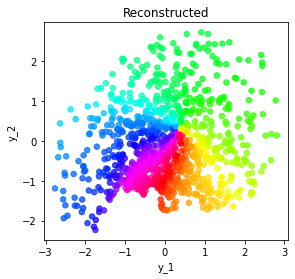

In [29]:
scatterplot_variables(Y, 'Reconstructed', colors=colors, savefig=False)#, fname="Reconstructed_flow")

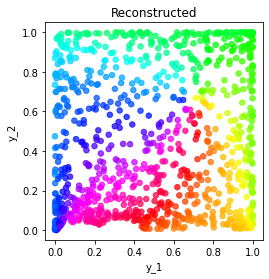

In [30]:
from jax.scipy.special import erf, erfinv
cdf_gaussian = lambda x : 0.5*(1.0 + erf(x))
inv_cdf_gaussian = lambda x : erfinv(2.0*x - 1.0)

Y_ = cdf_gaussian(Y)

scatterplot_variables(Y_, 'Reconstructed', colors=colors, savefig=False)#, fname="Reconstructed_flow")

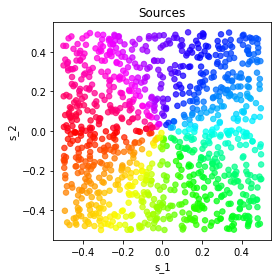

In [31]:
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

5. Hungarian algorithm; mean correlation coefficient; plots

In [32]:
import matplotlib.pyplot as plt

Correlation true-recovered sources:  0.8160582567436174


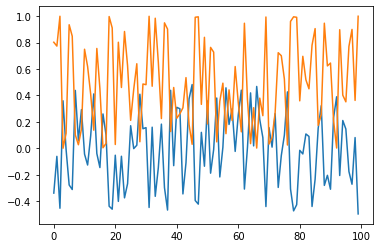

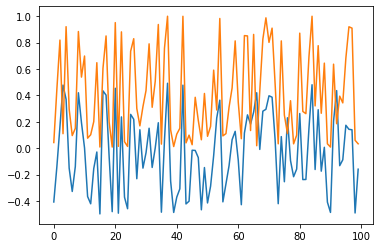

In [33]:
from solve_hungarian import SolveHungarian

# Y_ = S

av_corr, _, indices = SolveHungarian(recov=Y_, source=S)

print('Correlation true-recovered sources: ', av_corr)

plt.figure()
end = 100
for i in range(S.shape[1]):
    plt.plot(S[:end, indices[1][i]])
    plt.plot(Y_[:end,indices[0][i]])
    plt.show()

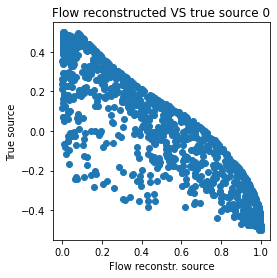

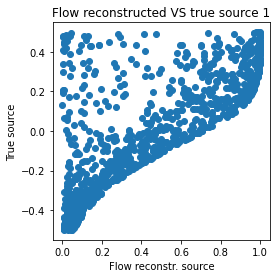

In [34]:
for i in range(2):
    plt.scatter(Y_[:,indices[0][i]], S[:,indices[1][i]])#, color='r', s=30)
    plt.xlabel('Flow reconstr. source')
    plt.ylabel('True source')
    plt.title('Flow reconstructed VS true source '+str(i))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

6. Compare Jacobians of the learned transformation and of the true mixing

In [35]:
# Average Jacobian of the true solution
ave_jac_true = np.mean(Jmixing_batched(S), axis=0)
print(ave_jac_true)

[[-0.20911379 -0.13296473]
 [ 0.13296473 -0.20911379]]


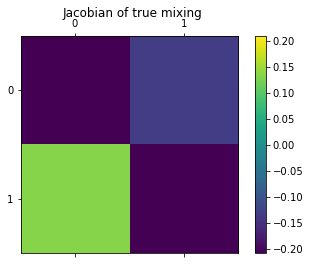

In [36]:
f, ax = plt.subplots(1, 1)
plt.suptitle('Jacobian of true mixing')
m = np.max(np.abs(ave_jac_true))
im = ax.matshow(ave_jac_true, vmin=-m, vmax=m)
f.colorbar(im)
plt.show()

In [37]:
# Average Jacobian of the flow based solution
ave_jac_flow = np.mean(Jflow_batched(Y), axis=0)
print(ave_jac_flow)

[[ 0.05724791 -0.04810591]
 [ 0.03031006  0.03855649]]


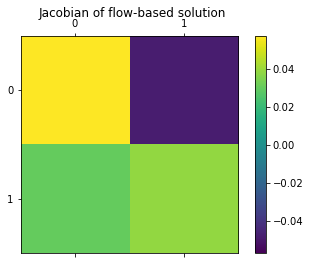

In [38]:
f, ax = plt.subplots(1, 1)
plt.suptitle('Jacobian of flow-based solution')
m = np.max(np.abs(ave_jac_flow))
im = ax.matshow(ave_jac_flow, vmin=-m, vmax=m)
f.colorbar(im)
plt.show()